### Loading the Data

In [69]:
import pickle
import numpy as np

In [70]:
with open('train_qa.txt','rb') as f: # Unpickling 
    train_data=pickle.load(f)

In [71]:
with open('test_qa.txt','rb') as f:  # Unpickling
    test_data=pickle.load(f)

### Exploring the format of the Data

In [72]:
len(train_data)

10000

In [73]:
len(test_data)

1000

In [74]:
all_data=test_data+train_data

In [75]:
len(all_data)

11000

----------------------------------
### Setting up vocabulary of all words

In [76]:
vocab=set()
for story,ques,ans in all_data:
    vocab=vocab.union(set(story))
    vocab=vocab.union(set(ques))

In [77]:
vocab.add('no')

In [78]:
vocab.add('yes')

In [79]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

### Vectorizing the data

In [80]:
vocab_len=len(vocab)+1

In [81]:
vocab_len

38

In [82]:
# Longest Story
all_story_len=[len(data[0]) for data in all_data]

In [83]:
max_story_len=max(all_story_len)

In [84]:
max_ques_len=max([len(data[1]) for data in all_data])

In [85]:
max_ques_len

6

In [86]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer 

In [87]:
# integer encode sequences of words 

tokenizer= Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [88]:
tokenizer.word_index

{'down': 1,
 'mary': 2,
 'picked': 3,
 'bedroom': 4,
 'went': 5,
 'football': 6,
 'travelled': 7,
 'grabbed': 8,
 'bathroom': 9,
 'john': 10,
 '.': 11,
 'back': 12,
 'journeyed': 13,
 'kitchen': 14,
 'moved': 15,
 'took': 16,
 'up': 17,
 'in': 18,
 'daniel': 19,
 'no': 20,
 'dropped': 21,
 'garden': 22,
 'left': 23,
 'sandra': 24,
 'discarded': 25,
 'put': 26,
 '?': 27,
 'the': 28,
 'apple': 29,
 'to': 30,
 'milk': 31,
 'office': 32,
 'yes': 33,
 'got': 34,
 'is': 35,
 'hallway': 36,
 'there': 37}

In [89]:
train_story_text=[]
train_ques_text=[]
train_answer=[]

In [90]:
for story,ques,ans in train_data:
    train_story_text.append(story)
    train_ques_text.append(ques)
    train_answer.append(ans)

In [91]:
train_story_seq=tokenizer.texts_to_sequences(train_story_text)

### Functionalize Vectorization

In [92]:
def vectorize_stories(data,word_index=tokenizer.word_index,max_story_len=max_story_len,max_ques_len=max_ques_len ):
    # Stories=X
    X=[]
    # Questions=Xq
    Xq=[]
    # Y Correct Answer (Yes/No)
    Y=[]
    
    for story,query,answer in data:
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
         # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y=np.zeros(len(word_index)+1)
        
        y[word_index[answer]] =1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
        # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return(pad_sequences(X,maxlen=max_story_len),pad_sequences(Xq,maxlen=max_ques_len),np.array(Y))

In [93]:
inputs_train,queries_train, answer_train=vectorize_stories(train_data)
inputs_test,queries_test, answer_test=vectorize_stories(test_data)


In [94]:
inputs_test

array([[ 0,  0,  0, ..., 28,  4, 11],
       [ 0,  0,  0, ..., 28, 22, 11],
       [ 0,  0,  0, ..., 28, 22, 11],
       ...,
       [ 0,  0,  0, ..., 28, 29, 11],
       [ 0,  0,  0, ..., 28, 22, 11],
       [ 0,  0,  0, ..., 29, 37, 11]], dtype=int32)

In [95]:
tokenizer.word_index['yes']

33

In [96]:
tokenizer.word_index['no']

20

In [97]:
sum(answer_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 503.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
       497.,   0.,   0.,   0.,   0.])

### Creating the model

In [98]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

In [99]:
# PlaceHolder for input  shape=(max_story_len,batch_size)
input_sequence=Input(max_story_len,)
question=Input((max_ques_len,))

In [100]:
vocab_size=len(vocab)+1

In [101]:
# INPUT ENCODER M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

#(samples,story_maxlen,embedding_dim)A

In [102]:
# INPUT ENCODER C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_ques_len))
input_encoder_c.add(Dropout(0.3))

#(samples,story_maxlen,max_ques_len)

In [103]:
# QUESTION ENCODER 
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,output_dim=64,input_length=max_ques_len))
question_encoder.add(Dropout(0.3))

#(samples,query_maxlen,embedding_dim)

In [104]:
# ENCODED <----- ENCODER(Input)
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded= question_encoder(question)


##### Use dot product to compute the match between first input vector seq and the query

In [105]:
match= dot([input_encoded_m,question_encoded],axes=(2,2))
match=Activation('softmax')(match)


#### Add this match matrix with the second input vector sequence

In [106]:
response= add([match,input_encoded_c])
response=Permute((2,1))(response)

#### Concatenate

In [107]:
# concatenate the match matrix with the question vector sequence

answer=concatenate([response,question_encoded])

In [108]:
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate_1')>

In [109]:
# Reduce with RNN (LSTM)

answer=LSTM(32)(answer)

In [110]:
# Regularization with Dropout

answer=Dropout(0.5)(answer)
answer=Dense(vocab_size)(answer) # (sample,vocab_size)

In [111]:
model=Model([input_sequence,question],answer)

In [112]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [113]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 156)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, None, 64)     2432        input_3[0][0]                    
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 6, 64)        2432        input_4[0][0]                    
____________________________________________________________________________________________

In [114]:
history=model.fit([inputs_train,queries_train],answer_train,batch_size=32,epochs=120,validation_data=([inputs_test,queries_test],answer_test))

Epoch 1/120
313/313 [==============================] - 4s 7ms/step - loss: 9.5433 - accuracy: 0.2970 - val_loss: 16.1181 - val_accuracy: 0.5030
Epoch 2/120
313/313 [==============================] - 2s 7ms/step - loss: 11.3759 - accuracy: 0.3721 - val_loss: 16.1181 - val_accuracy: 0.5030
Epoch 3/120
313/313 [==============================] - 2s 7ms/step - loss: 14.0032 - accuracy: 0.4725 - val_loss: 16.1181 - val_accuracy: 0.5030
Epoch 4/120
313/313 [==============================] - 2s 6ms/step - loss: 12.4782 - accuracy: 0.4604 - val_loss: 16.1181 - val_accuracy: 0.5030
Epoch 5/120
313/313 [==============================] - 2s 7ms/step - loss: 10.3945 - accuracy: 0.4710 - val_loss: 8.0107 - val_accuracy: 0.5030
Epoch 6/120
313/313 [==============================] - 2s 6ms/step - loss: 8.1825 - accuracy: 0.4660 - val_loss: 8.0107 - val_accuracy: 0.5030
Epoch 7/120
313/313 [==============================] - 2s 7ms/step - loss: 8.4837 - accuracy: 0.4814 - val_loss: 8.0107 - val_accuracy

Epoch 58/120
313/313 [==============================] - 3s 9ms/step - loss: 10.4308 - accuracy: 0.4934 - val_loss: 8.0107 - val_accuracy: 0.5030
Epoch 59/120
313/313 [==============================] - 3s 9ms/step - loss: 10.4300 - accuracy: 0.4940 - val_loss: 8.0107 - val_accuracy: 0.5030
Epoch 60/120
313/313 [==============================] - 3s 9ms/step - loss: 10.3136 - accuracy: 0.4893 - val_loss: 8.0107 - val_accuracy: 0.5030
Epoch 61/120
313/313 [==============================] - 3s 9ms/step - loss: 10.1314 - accuracy: 0.5001 - val_loss: 8.0107 - val_accuracy: 0.5030
Epoch 62/120
313/313 [==============================] - 3s 9ms/step - loss: 9.7559 - accuracy: 0.4968 - val_loss: 8.0107 - val_accuracy: 0.5030
Epoch 63/120
313/313 [==============================] - 3s 8ms/step - loss: 9.9226 - accuracy: 0.5004 - val_loss: 8.0107 - val_accuracy: 0.5030
Epoch 64/120
313/313 [==============================] - 2s 8ms/step - loss: 9.9034 - accuracy: 0.5021 - val_loss: 8.0107 - val_accur

Epoch 115/120
313/313 [==============================] - 2s 7ms/step - loss: 9.1051 - accuracy: 0.5001 - val_loss: 8.0107 - val_accuracy: 0.5030
Epoch 116/120
313/313 [==============================] - 3s 9ms/step - loss: 9.2465 - accuracy: 0.5030 - val_loss: 8.0107 - val_accuracy: 0.5030
Epoch 117/120
313/313 [==============================] - 3s 8ms/step - loss: 9.2594 - accuracy: 0.4938 - val_loss: 8.0107 - val_accuracy: 0.5030
Epoch 118/120
313/313 [==============================] - 3s 9ms/step - loss: 9.1891 - accuracy: 0.4959 - val_loss: 8.0107 - val_accuracy: 0.5030
Epoch 119/120
313/313 [==============================] - 3s 8ms/step - loss: 9.3804 - accuracy: 0.4975 - val_loss: 8.0107 - val_accuracy: 0.5030
Epoch 120/120
313/313 [==============================] - 2s 7ms/step - loss: 9.5014 - accuracy: 0.5031 - val_loss: 8.0107 - val_accuracy: 0.5030


In [115]:
filename = 'chatbot_120epoch.h5'
model.save(filename)

## Evaluating the model

### Plotting our training history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


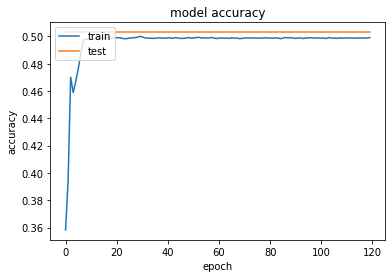

In [116]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluating on given testset

In [117]:
model.load_weights('chatbot_120epoch.h5')

In [118]:
pred_results=model.predict(([inputs_test,queries_test]))

In [119]:
pred_results.shape

(1000, 38)

In [120]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [121]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [122]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [123]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  10.831581


## Writing our own story and questions.

In [124]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [125]:
my_story="John left the kitchen . Sandra dropped the football in the garden ."

In [126]:
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [127]:
my_question="Is the football in the garden ?"

In [128]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [129]:
my_data=[(my_story.split(),my_question.split(),'yes')]

In [130]:
my_data

[(['John',
   'left',
   'the',
   'kitchen',
   '.',
   'Sandra',
   'dropped',
   'the',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'the', 'football', 'in', 'the', 'garden', '?'],
  'yes')]

In [131]:
my_story, my_question, my_ans=vectorize_stories(my_data)

In [132]:
my_data

[(['John',
   'left',
   'the',
   'kitchen',
   '.',
   'Sandra',
   'dropped',
   'the',
   'football',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'the', 'football', 'in', 'the', 'garden', '?'],
  'yes')]

In [133]:
my_story

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,
        23, 28, 14, 11, 24, 21, 28,  6, 18, 28, 22, 11]], dtype=int32)

In [134]:
pred_results=model.predict(([my_story,my_question]))

In [135]:
pred_results.shape

(1, 38)

In [136]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  10.834788
